# Empirical Data Inference
Infer evolutionary parameters from empirical data with the ensemble density estimators.

In [1]:
import torch
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from model.simulator import simulate
from utils import get_ensemble_predictions, calc_stats, sbi_post, get_mode_and_hdi, grab_short_sumstat, grab_long_sumstat, grab_man_sumstat
from model.params import readable_prior as prior 
from plotting import plot_from_post, set_plots_size_params, compare_posts, short_sumstats_plot, compare_posts_across_lines
set_plots_size_params(20)

In [2]:
rename_dict = {'mu': 'Mutation\nRate', 'w_syn': 'Syn\nEffect', 'w_non_syn': 'Non-Syn\nEffect',
               'w_ada': 'Beneficial\nEffect', 'p_ada_syn': 'Beneficial\nSyn\nProbability',
               'p_ada_non_syn': 'Beneficial\nNon-Syn\nProbability', 'p0_syn': 'P0 Syn',
               'p0_non_syn': 'P0\nNon-Syn', 'w_penalty': 'P0 Penalty', 
               'epistasis_boost': 'Epistasis\nFitness\nBoost'}

In [3]:
def infer_and_plot(ensemble_path, input_data, man_sumstat, syn_prob, sumstats_to_simulate=10,
                   plot_hdi=True, plot_short_PPC=True, plot_long_PPC=True, plot_freqs=True, samples_per_model=200):
    post, stats = get_ensemble_predictions(ensemble_path, input_data, None, prior, samples_per_model=samples_per_model)
    print(stats[stats.model=='ensemble'])
    post = post.rename(columns=rename_dict)
    post = post[rename_dict.values()]
    simulated_data = plot_from_post(post, stats, man_sumstat, num_of_samples=sumstats_to_simulate, syn_prob=syn_prob,
                                    plot_hdi=plot_hdi, plot_short_PPC=plot_short_PPC, plot_freqs=plot_freqs,
                                    plot_long_PPC=plot_long_PPC)
    return post, stats, simulated_data


In [4]:
# EB=1 --> no epistasis!, 0<EB<1 --> weak negative, EB<0 --> sign epistasis!
# PP=0 --> P0 muts are neutral, PP=1 --> P0 muts are not as deleterious as the rest of the muts

In [5]:
loop_coding = {}
loop_coding_short = {}
loop_coding_man = {}

def grab_long(sumstat):
    return sumstat[:204]

def grab_short(sumstat):
    return sumstat[:6]

def grab_man(sumstat):
    return np.concatenate((sumstat[:6],sumstat[204:]))

line_replica = {1: 'A', 2: 'B', 3: 'C'}

for i in range(1,4):
    total_coding_sumstat = torch.load(join('data_analysis', f'line{i}_total_sumstat.pt'))
    loop_coding[line_replica[i]] = grab_long(total_coding_sumstat)
    loop_coding_man[line_replica[i]] = grab_man(total_coding_sumstat)
    loop_coding_short[line_replica[i]] = grab_short(total_coding_sumstat)

syn_prob = 0.278

In [6]:
def get_ensemble_path(errs, replica, sumstat_type):
    return join('density_estimators', f'{errs} error rate', 'ensembles', replica, sumstat_type)


# LR Inference

In [7]:
inf_LR = {}

In [8]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.554000  -1.435555  1.130328    0.272086  -0.836423   
1            w_syn  0.840500   0.517362  1.000425    0.999918   0.798459   
2        w_non_syn  0.689000   0.227306  0.750196    0.944942   0.510971   
3            w_ada  1.646000   1.160596  0.913780    2.384670   1.442555   
4        p_ada_syn  0.000611   0.000001  1.203466    0.003916   0.000202   
5    p_ada_non_syn  0.007850   0.003190  0.765645    0.009998   0.006554   
6           p0_syn  0.537000   0.450074  0.707011    0.599544   0.512248   
7       p0_non_syn  0.767000   0.706718  0.638356    0.879712   0.756422   
8        w_penalty  0.089900   0.000038  0.965252    1.250809   0.001063   
9  epistasis_boost  0.374000  -0.931845  0.844140    1.771817   0.026033   

   hdi50_high     model  
0   -0.295175  ensemble  
1    0.972217  ensemble  
2    0.785890  ensemble  
3    1.820464  ensemble  
4    0.001475  ensemble  
5    0.

In [9]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.67500  -1.809878  1.336361    0.246377  -0.973687   
1            w_syn  0.90600   0.466380  0.999845    0.999737   0.830861   
2        w_non_syn  0.74800   0.241252  0.742915    0.967481   0.586803   
3            w_ada  1.73300   1.109141  0.888021    2.466225   1.449912   
4        p_ada_syn  0.00184   0.000001  0.892091    0.005697   0.000895   
5    p_ada_non_syn  0.00745   0.002377  0.695425    0.009967   0.005215   
6           p0_syn  0.53900   0.448237  0.706476    0.599968   0.492029   
7       p0_non_syn  0.75300   0.700086  0.671069    0.859022   0.729188   
8        w_penalty  0.02995   0.000063  0.949889    1.311113   0.000165   
9  epistasis_boost  0.12750  -0.999897  0.864920    1.414615  -0.435612   

   hdi50_high     model  
0   -0.371362  ensemble  
1    0.998025  ensemble  
2    0.857141  ensemble  
3    1.840849  ensemble  
4    0.002969  ensemble  
5    0.008316  ens

In [10]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -1.039000  -2.098214  1.819519   -0.070498  -1.321884   
1            w_syn  0.975000   0.443259  1.012955    0.999742   0.843964   
2        w_non_syn  0.827000   0.275463  0.774071    0.995883   0.681469   
3            w_ada  2.042000   1.481541  0.864723    2.706486   1.739941   
4        p_ada_syn  0.001043   0.000004  1.261925    0.003407   0.000569   
5    p_ada_non_syn  0.006950   0.002698  0.724622    0.009992   0.005465   
6           p0_syn  0.543000   0.466800  0.777630    0.599938   0.525488   
7       p0_non_syn  0.791000   0.704821  0.628870    0.878048   0.755266   
8        w_penalty  0.049100   0.000162  1.123232    1.155131   0.000162   
9  epistasis_boost  0.024465  -0.981322  0.969443    1.017837  -0.360607   

   hdi50_high     model  
0   -0.683081  ensemble  
1    0.995515  ensemble  
2    0.920121  ensemble  
3    2.159929  ensemble  
4    0.001783  ensemble  
5    0.

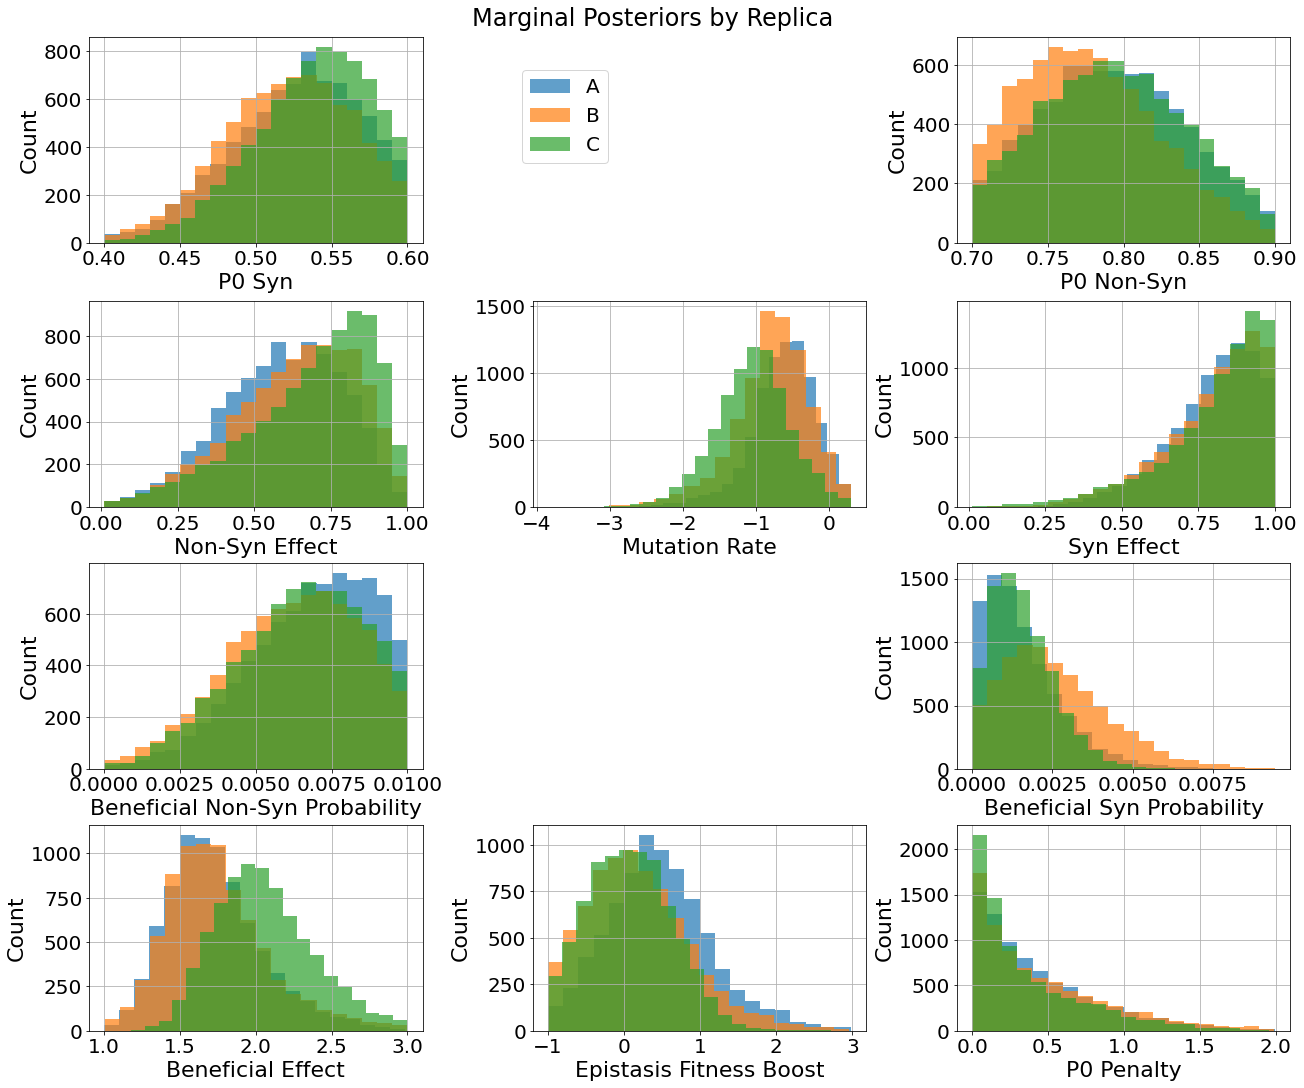

In [11]:
compare_posts_across_lines(inf_LR)

# L-LR Inference

In [12]:
inf_LLR = {}

## Figure 6

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.501500 -9.599491e-01  1.345608   -0.022239  -0.670881   
1            w_syn  0.903000  6.570272e-01  1.291330    0.999991   0.839164   
2        w_non_syn  0.743500  4.076234e-01  0.960362    0.934214   0.654118   
3            w_ada  1.796000  1.482432e+00  1.332133    2.140018   1.637312   
4        p_ada_syn  0.000775  1.486579e-07  1.624510    0.002178   0.000234   
5    p_ada_non_syn  0.006250  3.043649e-03  0.745547    0.009969   0.004854   
6           p0_syn  0.493000  4.197279e-01  0.648110    0.589454   0.477532   
7       p0_non_syn  0.809000  7.104182e-01  0.636489    0.884097   0.763069   
8        w_penalty  0.170000  9.913703e-05  0.808192    1.412417   0.001089   
9  epistasis_boost -0.307000 -9.995441e-01  1.133761    0.509830  -0.526514   

   hdi50_high     model  
0   -0.364399  ensemble  
1    0.951005  ensemble  
2    0.836562  ensemble  
3    1.850837  ensemble  


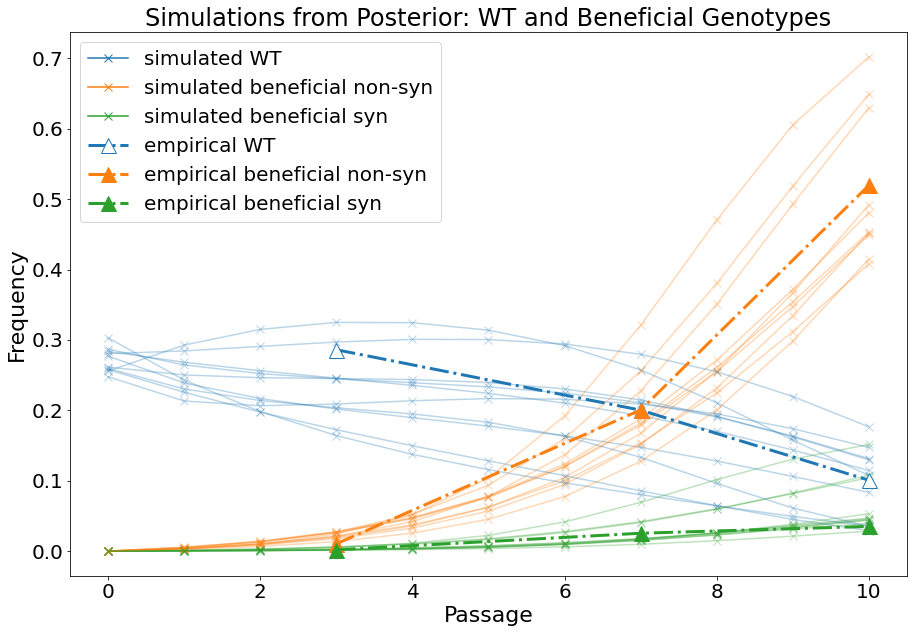

In [13]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=True, samples_per_model=1000, syn_prob=syn_prob)


In [14]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.748000  -1.147934  1.710709   -0.231345  -0.851451   
1            w_syn  0.848000   0.611363  1.176456    0.999223   0.800880   
2        w_non_syn  0.709000   0.252147  0.819383    0.896507   0.538428   
3            w_ada  1.778000   1.514581  1.513335    2.023204   1.694647   
4        p_ada_syn  0.001410   0.000005  1.483550    0.002512   0.000741   
5    p_ada_non_syn  0.007345   0.003464  0.778061    0.010000   0.005420   
6           p0_syn  0.523000   0.429065  0.644880    0.597924   0.480509   
7       p0_non_syn  0.785000   0.716344  0.640382    0.890754   0.766127   
8        w_penalty  0.047750   0.000145  1.238832    0.871536   0.007562   
9  epistasis_boost -0.394500  -0.997260  1.185224    0.440833  -0.565752   

   hdi50_high     model  
0   -0.538179  ensemble  
1    0.932934  ensemble  
2    0.771604  ensemble  
3    1.872138  ensemble  
4    0.001692  ensemble  
5    0.

In [15]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.906000  -1.381172  2.079958   -0.430920  -1.058558   
1            w_syn  0.938000   0.687697  1.346163    0.999948   0.869751   
2        w_non_syn  0.708000   0.315698  0.858149    0.925334   0.569463   
3            w_ada  1.986500   1.733651  1.385359    2.331696   1.910641   
4        p_ada_syn  0.000427   0.000002  1.794290    0.001727   0.000382   
5    p_ada_non_syn  0.006555   0.003209  0.766472    0.009990   0.004841   
6           p0_syn  0.507000   0.427343  0.651513    0.595535   0.483446   
7       p0_non_syn  0.815000   0.709277  0.637429    0.884328   0.767357   
8        w_penalty  0.025150   0.000041  1.435577    0.668007   0.000041   
9  epistasis_boost -0.377000  -0.999966  1.230215    0.367716  -0.665030   

   hdi50_high     model  
0   -0.747349  ensemble  
1    0.980739  ensemble  
2    0.788607  ensemble  
3    2.115834  ensemble  
4    0.001059  ensemble  
5    0.

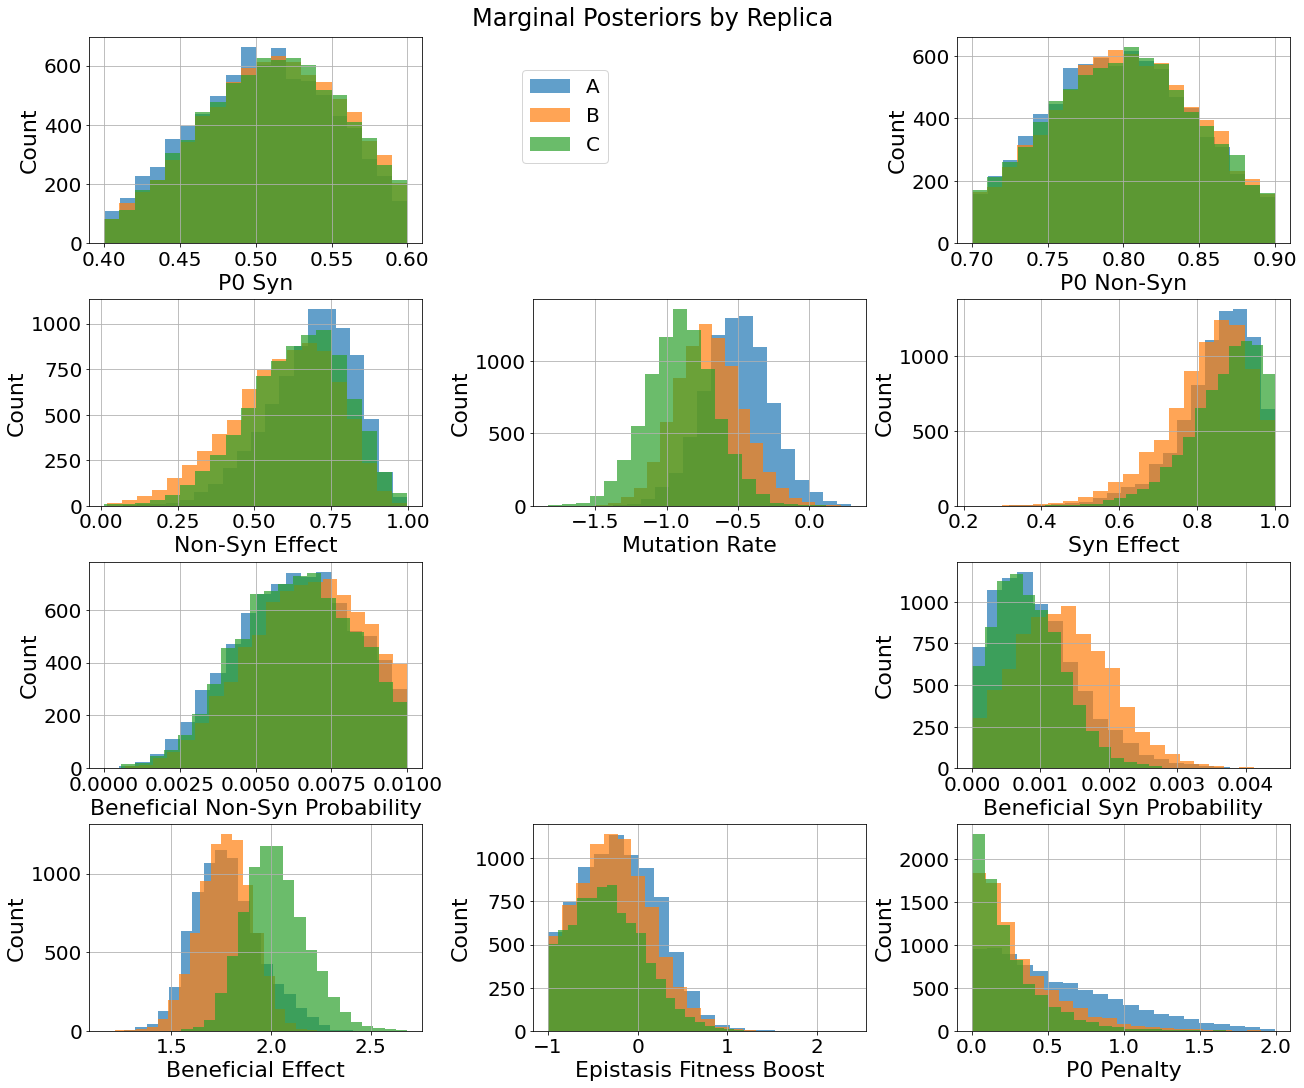

In [16]:
compare_posts_across_lines(inf_LLR)

# SR Inference

In [17]:
inf_SR = {}

In [18]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.65000  -1.702555  1.381190    0.187686  -1.137086   
1            w_syn  0.90700   0.459765  0.973877    0.999781   0.818658   
2        w_non_syn  0.71800   0.275324  0.739267    0.998495   0.605202   
3            w_ada  2.19100   1.284179  0.717759    2.811770   1.756168   
4        p_ada_syn  0.00215   0.000013  0.872480    0.006153   0.001005   
5    p_ada_non_syn  0.00746   0.002693  0.719922    0.009999   0.005773   
6           p0_syn  0.55900   0.463628  0.756155    0.599908   0.529418   
7       p0_non_syn  0.78300   0.703598  0.653000    0.874531   0.761485   
8        w_penalty  0.04940   0.000024  1.067416    1.266379   0.000024   
9  epistasis_boost -0.02298  -0.997333  0.907003    1.245480  -0.379859   

   hdi50_high     model  
0   -0.455050  ensemble  
1    0.993782  ensemble  
2    0.885250  ensemble  
3    2.325082  ensemble  
4    0.003183  ensemble  
5    0.008847  ens

In [19]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.77900  -1.895945  1.424441    0.255660  -1.230756   
1            w_syn  0.90700   0.447366  0.953299    0.999984   0.814836   
2        w_non_syn  0.85700   0.228457  0.706919    0.974684   0.574528   
3            w_ada  2.15100   1.265076  0.689893    2.867495   1.803717   
4        p_ada_syn  0.00265   0.000002  0.756653    0.007080   0.001456   
5    p_ada_non_syn  0.00665   0.002590  0.705383    0.009999   0.006063   
6           p0_syn  0.54900   0.451640  0.741502    0.599976   0.515439   
7       p0_non_syn  0.77700   0.703104  0.644708    0.870039   0.738418   
8        w_penalty  0.03010   0.000121  0.993031    1.392856   0.000391   
9  epistasis_boost -0.18200  -0.998323  0.898000    1.334147  -0.393682   

   hdi50_high     model  
0   -0.448053  ensemble  
1    0.990211  ensemble  
2    0.873088  ensemble  
3    2.409222  ensemble  
4    0.004006  ensemble  
5    0.009075  ens

In [20]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.72750  -1.821992  1.367284    0.164440  -1.077663   
1            w_syn  0.93650   0.436841  0.934809    0.999923   0.775915   
2        w_non_syn  0.82700   0.285853  0.749791    0.987612   0.605219   
3            w_ada  2.06000   1.380780  0.702211    2.921857   1.879943   
4        p_ada_syn  0.00214   0.000009  0.913347    0.005710   0.001023   
5    p_ada_non_syn  0.00806   0.002746  0.715467    0.009996   0.005409   
6           p0_syn  0.53300   0.447521  0.699081    0.599597   0.507336   
7       p0_non_syn  0.76900   0.702393  0.651911    0.868866   0.754552   
8        w_penalty  0.05000   0.000013  1.004497    1.448665   0.000013   
9  epistasis_boost -0.10600  -0.999445  0.950751    1.112712  -0.407051   

   hdi50_high     model  
0   -0.357531  ensemble  
1    0.967016  ensemble  
2    0.885353  ensemble  
3    2.461262  ensemble  
4    0.003057  ensemble  
5    0.008404  ens

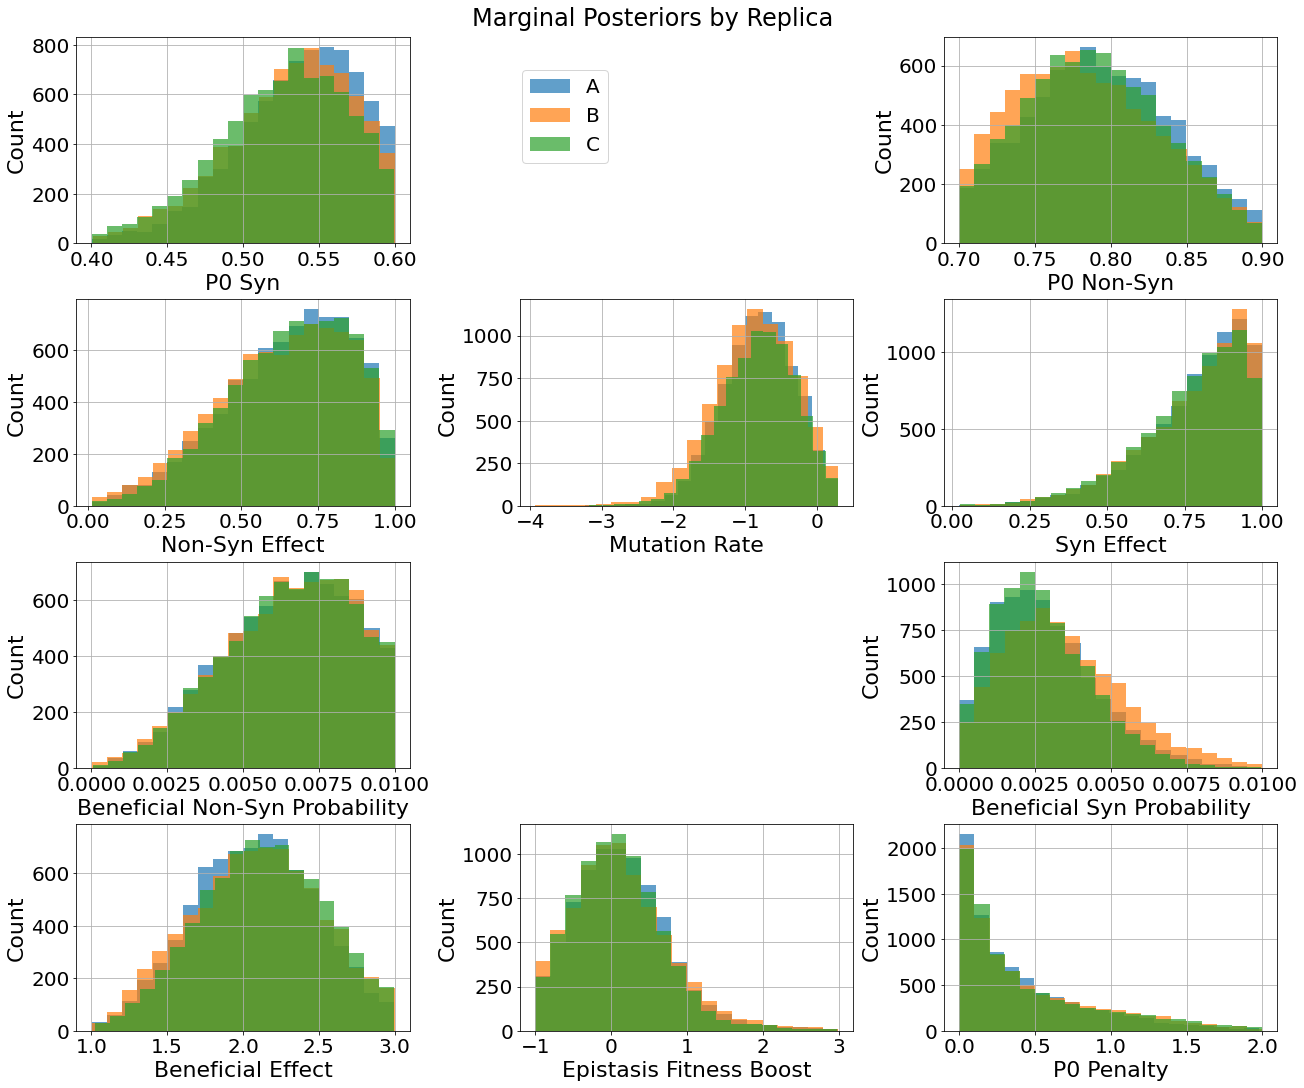

In [21]:
compare_posts_across_lines(inf_SR)

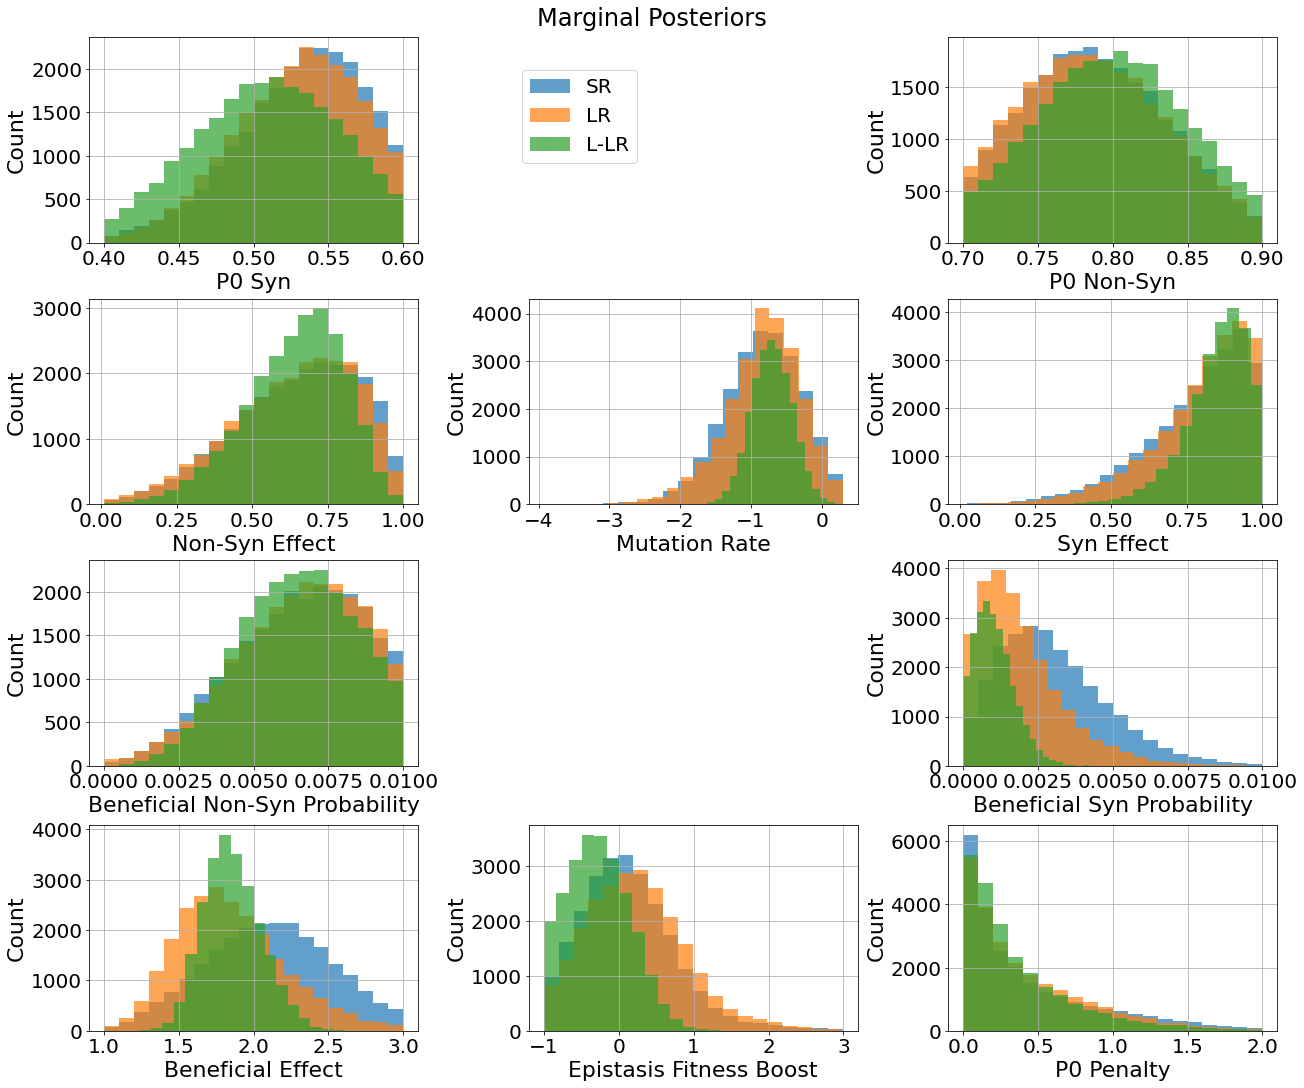

In [22]:
all_posts = {'SR': pd.concat([x[0] for x in inf_SR.values()]),
             'LR': pd.concat([x[0] for x in inf_LR.values()]),
             'L-LR': pd.concat([x[0] for x in inf_LLR.values()])}
compare_posts(all_posts)

In [23]:
def compare_posts_for_paper(posts, title_suffix='', colors=None, alpha=0.7, mu_xticks=(-3,1)):
    fig, axes = plt.subplots(3, 3, figsize=(18,15), constrained_layout=True)
    ax_dict = {'Mutation\nRate': (0,1), 'Syn\nEffect': (0,2), 'Non-Syn\nEffect': (0,0), 
               'Beneficial\nEffect': (2,0), 'P0 Penalty': (2,2), 
               'Epistasis\nFitness\nBoost': (2,1), 
               'Beneficial\nSyn\nProbability': (1,2), 'Beneficial\nNon-Syn\nProbability': (1,0)}
    if not colors:
        colors = sns.color_palette(None)
    title = 'Marginal Posteriors'
    title += title_suffix
    #fig.suptitle(title)
    legend = True
    for col_name, ax_index in ax_dict.items():
        ax = axes[ax_index]
        col = 'err' if 'Mutation' in col_name else 'rel_err'
        for i, (name, df) in enumerate(posts.items()):
            df[col_name].hist(bins=20, label=name if legend else '_nolegend', ax=ax, alpha=alpha, color=colors[i])
            if 'Mutation' in col_name:
                xticks = range(mu_xticks[0],mu_xticks[1])
                ax.set_xticks(xticks)
                ax.set_xticklabels([10**x for x in xticks])
            if 'Probability' in col_name:
                ax.set_xticks([0, 0.005, 0.01])
                #ax.set_xticklabels([10**x for x in xticks])
            if 'stasis' in col_name:
                ax.axvline(0.5, ls='--', color='k')    
        ax.set_xlabel(col_name.replace('\n', ' '))
        if 'Penalty' in col_name:
            ax.set_xlabel('P0 log-fitness Correlation')
        ax.set_ylabel('Count')
        legend = False
    fig.delaxes(axes[(1,1)])
    #fig.delaxes(axes[(2,1)])
    fig.legend(loc=(0.46,0.46))


## Fig 5B

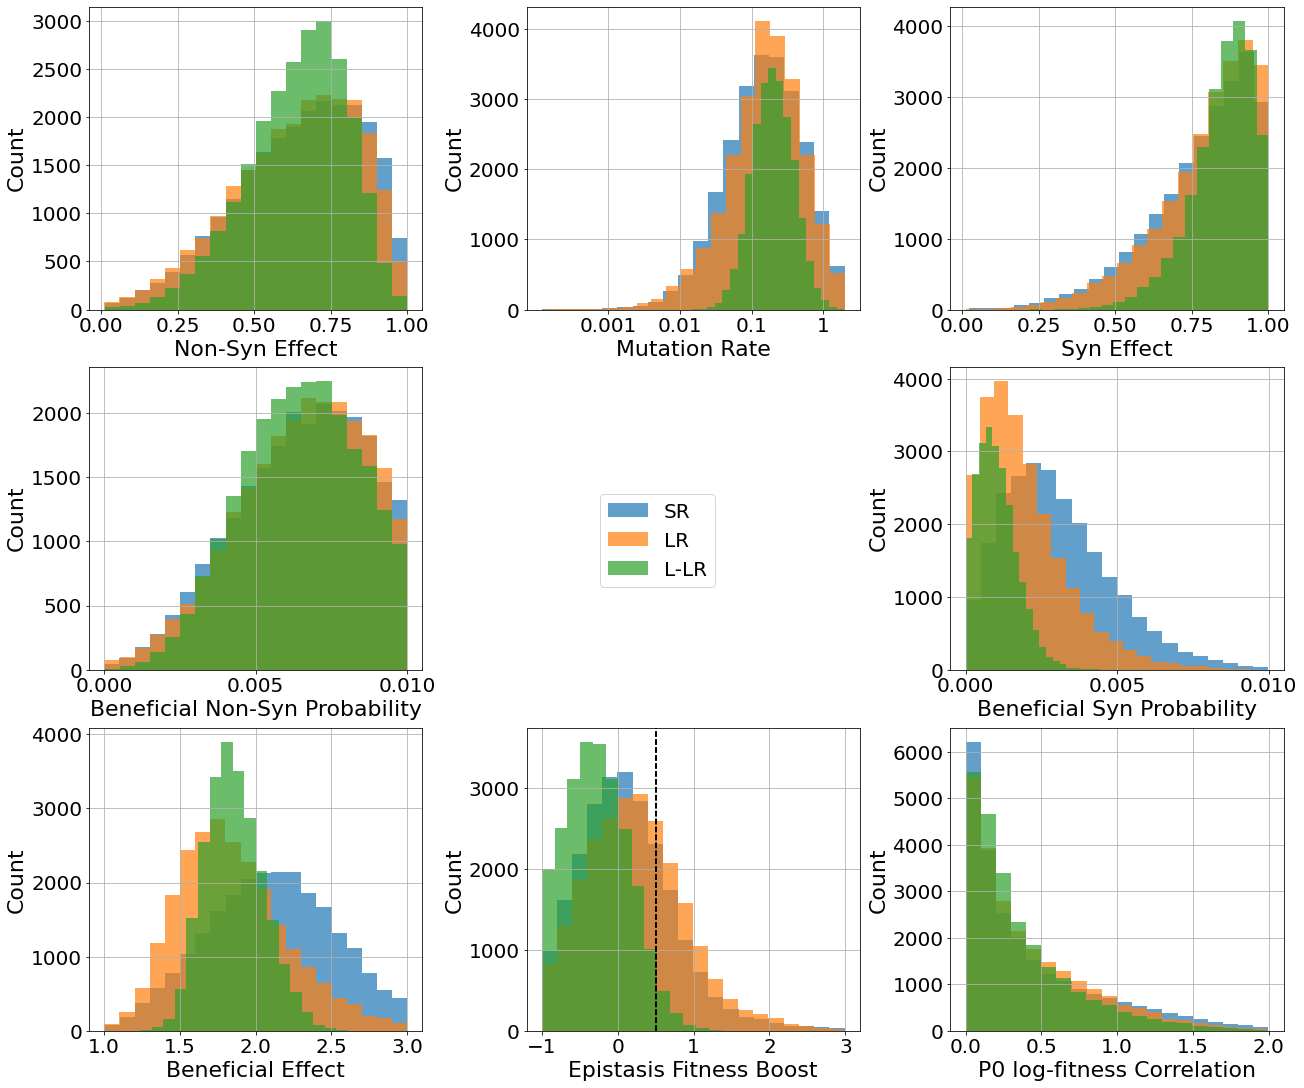

In [24]:
compare_posts_for_paper({'SR': all_posts['SR'], 'LR': all_posts['LR'], 'L-LR': all_posts['L-LR']})

## Table 1 + Table S2 data

In [25]:
all_posts_tmp = {k :v.rename(columns={v:k for k,v in rename_dict.items()}) for k,v in all_posts.items()}
stats = {k : calc_stats(v, None, prior) for k,v in all_posts_tmp.items()}
for k, v in stats.items():
    for param in v.param.unique():
        print(k)
        print(param)
        print(v[v.param==param][['hdi95_low', 'mode', 'hdi95_high']])

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


SR
mu
   hdi95_low   mode  hdi95_high
0  -1.826617 -0.736    0.193739
SR
w_syn
   hdi95_low   mode  hdi95_high
1   0.448907  0.907    0.999984
SR
w_non_syn
   hdi95_low   mode  hdi95_high
2   0.269005  0.728    0.993308
SR
w_ada
   hdi95_low   mode  hdi95_high
3   1.344777  2.151    2.915342
SR
p_ada_syn
   hdi95_low     mode  hdi95_high
4   0.000007  0.00255    0.006381
SR
p_ada_non_syn
   hdi95_low     mode  hdi95_high
5   0.002673  0.00725    0.009999
SR
p0_syn
   hdi95_low   mode  hdi95_high
6   0.453874  0.549    0.599963
SR
p0_non_syn
   hdi95_low   mode  hdi95_high
7   0.702581  0.777    0.870963
SR
w_penalty
   hdi95_low  mode  hdi95_high
8   0.000013  0.05    1.379207
SR
epistasis_boost
   hdi95_low     mode  hdi95_high
9  -0.998113  0.01745    1.231545
LR
mu
   hdi95_low    mode  hdi95_high
0  -1.853131 -0.7995    0.185922
LR
w_syn
   hdi95_low   mode  hdi95_high
1   0.475485  0.896    0.999856
LR
w_non_syn
   hdi95_low   mode  hdi95_high
2   0.237029  0.827    0.968972
LR
w_

## Fig 5A

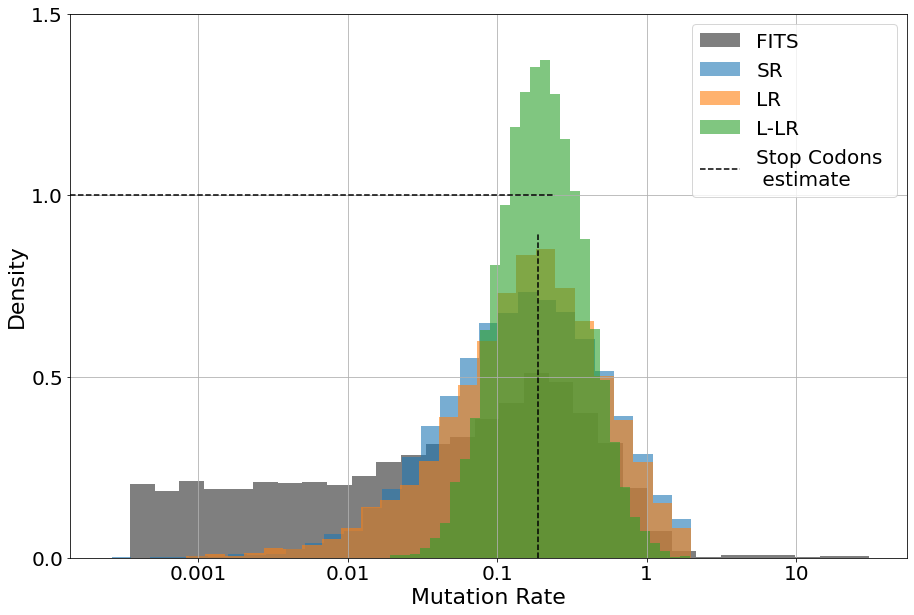

In [26]:
fits_post = pd.read_table('FITS/fits_post.tsv')
sample_size = 10000
bin_num = 30
alpha = 0.6
fits_post.log_U.sample(sample_size).hist(bins=bin_num, label='FITS', density=True, color=sns.color_palette()[7])
all_posts['SR']['Mutation\nRate'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='SR', density=True)
all_posts['LR']['Mutation\nRate'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='LR', density=True)
all_posts['L-LR']['Mutation\nRate'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='L-LR', density=True)
plt.ylabel('Density')
plt.legend()#loc=(1.1,0.8))

#plt.title('Mutation Rate Marginal Posterior')
plt.xlabel('Mutation Rate')
xticks = [-3,-2,-1,0, 1]
plt.xticks(xticks, labels=[10**x for x in xticks])
plt.yticks([0,0.5,1,1.5])
stop_codon_estimate = np.log10(0.187)
plt.axvline(stop_codon_estimate, ls='--', color='k', ymax=0.595)
plt.axhline(1, xmax=0.579, ls='--', color='k')
handles, labels = plt.gca().get_legend_handles_labels()
line = plt.Line2D([0], [0], label='Stop Codons \n estimate', color='k', ls='--')
handles.extend([line])
plt.legend(handles=handles)


# Large Errors (10x loop errs)

In [27]:
large_errs_LLR = {}

In [29]:
errs = '5e-04'
replica = 'A'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.924500  -1.433659  1.864975   -0.279896  -1.099379   
1            w_syn  0.846000   0.656230  1.275064    0.998295   0.797765   
2        w_non_syn  0.465000   0.113143  0.865315    0.710936   0.338870   
3            w_ada  1.845000   1.577488  1.343393    2.221202   1.699092   
4        p_ada_syn  0.000804   0.000011  1.839357    0.001684   0.000461   
5    p_ada_non_syn  0.008305   0.004066  0.835653    0.009999   0.007110   
6           p0_syn  0.503000   0.411431  0.635398    0.585356   0.468955   
7       p0_non_syn  0.795000   0.710814  0.655164    0.881310   0.759774   
8        w_penalty  0.350000   0.013401  0.835010    1.329325   0.158114   
9  epistasis_boost -0.501000  -0.999857  1.196600    0.450273  -0.846763   

   hdi50_high     model  
0   -0.700610  ensemble  
1    0.912112  ensemble  
2    0.553064  ensemble  
3    1.910148  ensemble  
4    0.001101  ensemble  
5    0.

In [30]:
errs = '5e-04'
replica = 'B'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.440000 -8.010796e-01  1.145315    0.079137  -0.551777   
1            w_syn  0.689000  4.945043e-01  1.205464    0.870946   0.634922   
2        w_non_syn  0.303000  4.839063e-02  1.082495    0.487883   0.210012   
3            w_ada  1.775000  1.542900e+00  1.402844    2.116988   1.704134   
4        p_ada_syn  0.000562  1.072601e-07  1.828117    0.001650   0.000290   
5    p_ada_non_syn  0.002055  5.526890e-04  1.158856    0.004627   0.001629   
6           p0_syn  0.479000  4.007420e-01  0.636155    0.573887   0.458806   
7       p0_non_syn  0.795000  7.082996e-01  0.641318    0.883717   0.758193   
8        w_penalty  1.914500  8.791609e-01  0.937350    1.999930   1.624282   
9  epistasis_boost -0.105700 -9.509362e-01  1.151418    0.599926  -0.414250   

   hdi50_high     model  
0   -0.250834  ensemble  
1    0.761998  ensemble  
2    0.365250  ensemble  
3    1.907661  ensemble  


In [31]:
errs = '5e-04'
replica = 'C'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.757000 -1.269879e+00  1.483085   -0.053584  -0.920352   
1            w_syn  0.858000  7.032551e-01  1.388898    0.992931   0.816153   
2        w_non_syn  0.441000  1.478560e-01  0.991759    0.647964   0.332555   
3            w_ada  1.911000  1.607165e+00  1.310797    2.273946   1.830477   
4        p_ada_syn  0.000762  1.895488e-07  1.811134    0.001694   0.000386   
5    p_ada_non_syn  0.004540  1.941798e-03  0.861186    0.008296   0.003754   
6           p0_syn  0.481000  4.025173e-01  0.637236    0.576886   0.454500   
7       p0_non_syn  0.777000  7.019747e-01  0.626823    0.878215   0.755379   
8        w_penalty  1.622500  6.478080e-01  0.777683    1.999998   1.392322   
9  epistasis_boost -0.457500 -9.991154e-01  1.216857    0.407479  -0.771213   

   hdi50_high     model  
0   -0.523768  ensemble  
1    0.918961  ensemble  
2    0.511318  ensemble  
3    2.051396  ensemble  


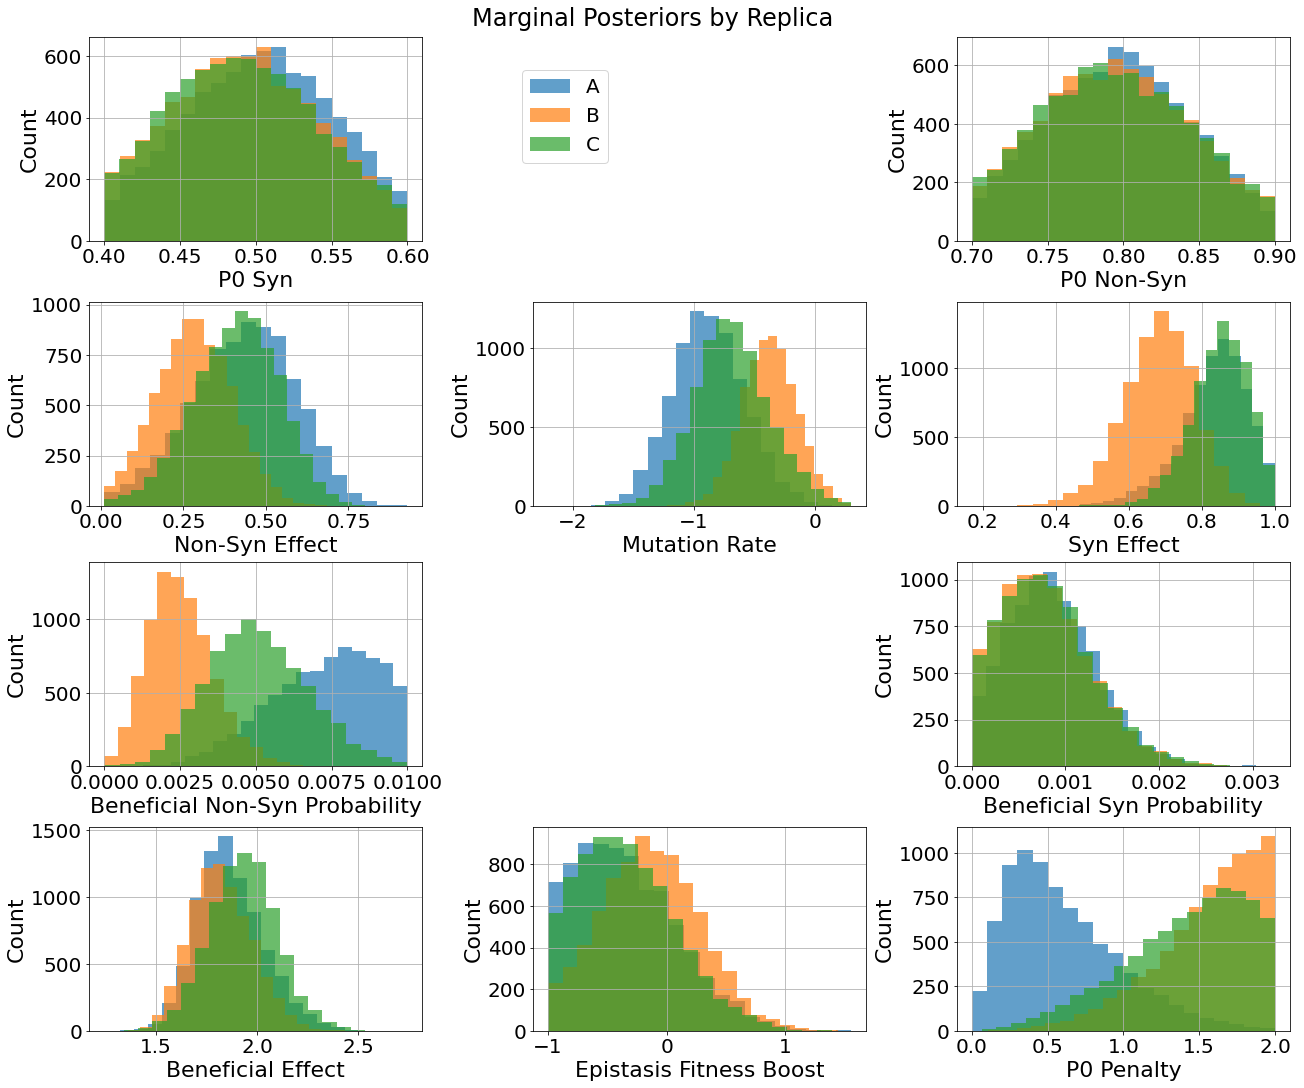

In [32]:
compare_posts_across_lines(large_errs_LLR)

## Fig S4

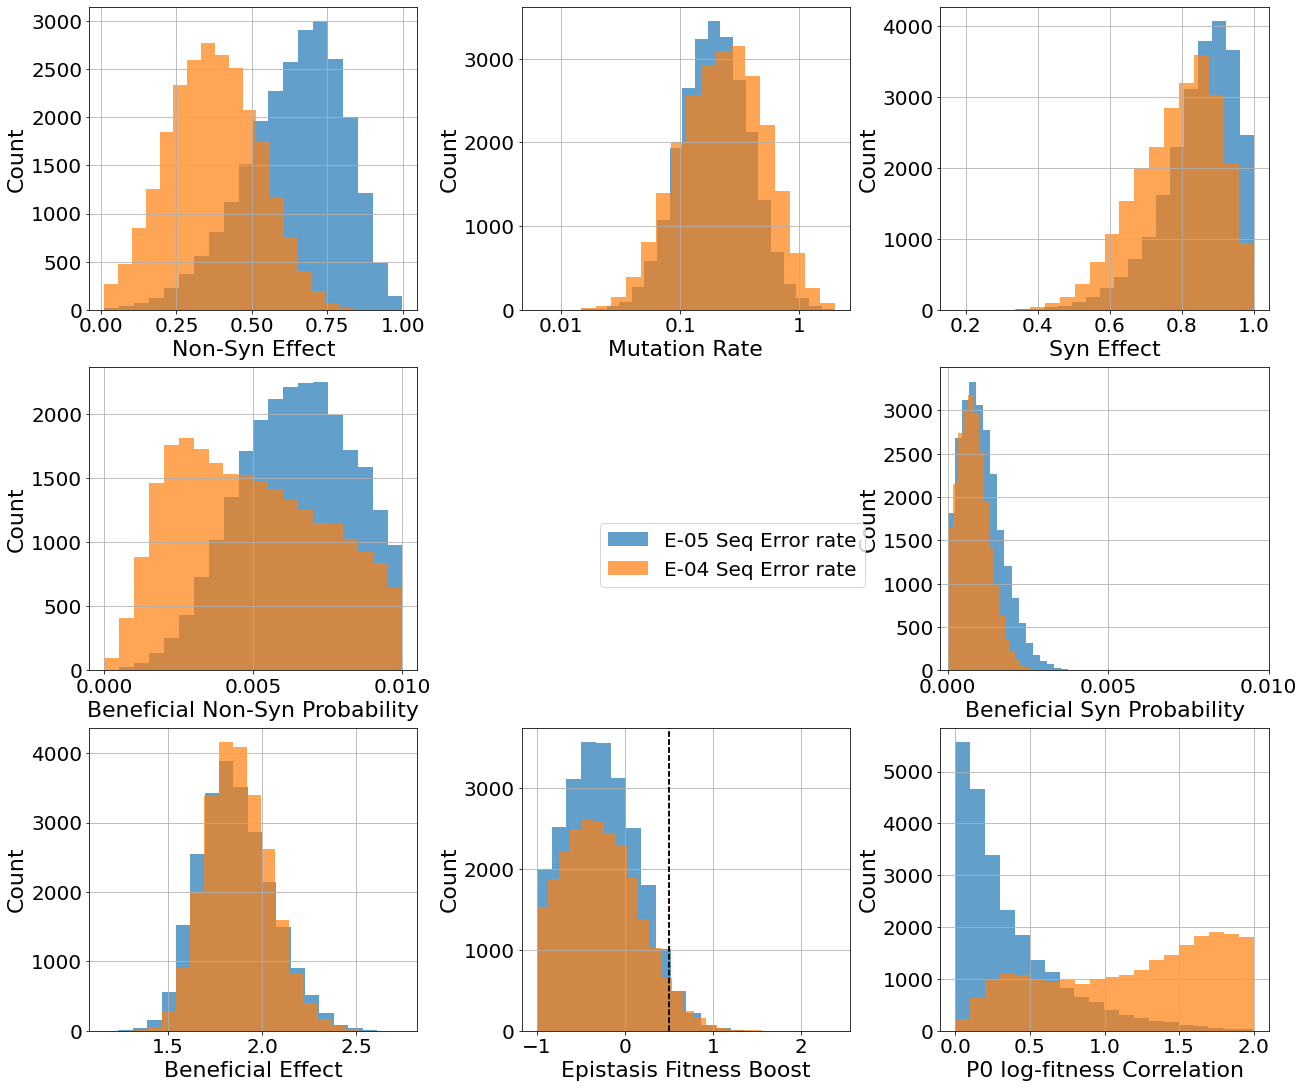

In [33]:
man_errs = {'E-05 Seq Error rate': pd.concat([x[0] for x in inf_LLR.values()]),
            'E-04 Seq Error rate': pd.concat([x[0] for x in large_errs_LLR.values()])}
compare_posts_for_paper(man_errs, mu_xticks=(-2,1))

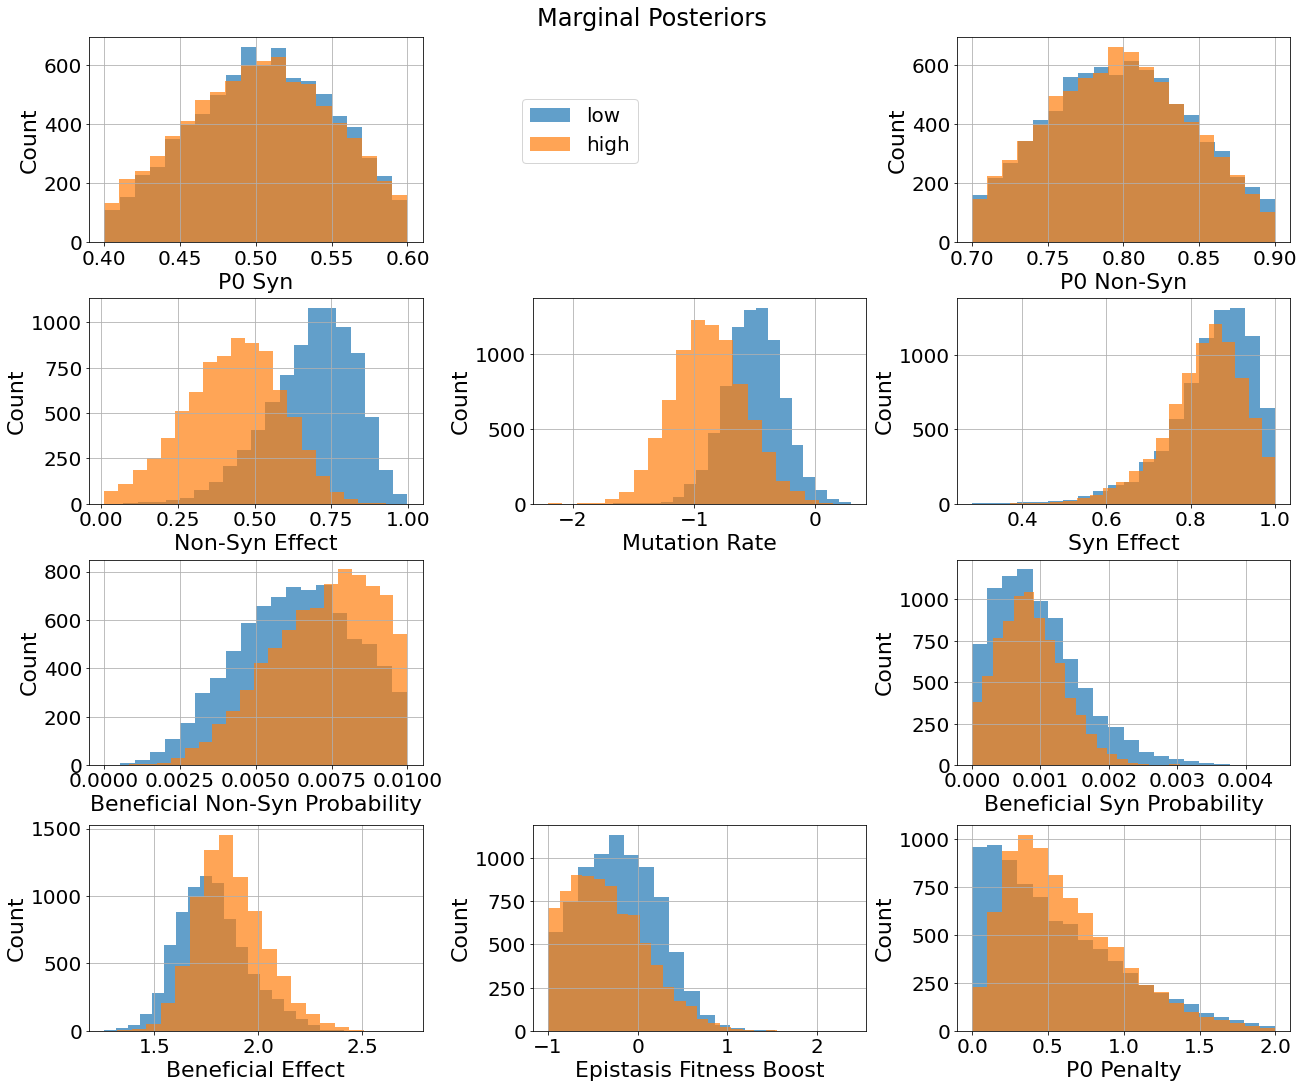

In [34]:
replica = 'A'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})

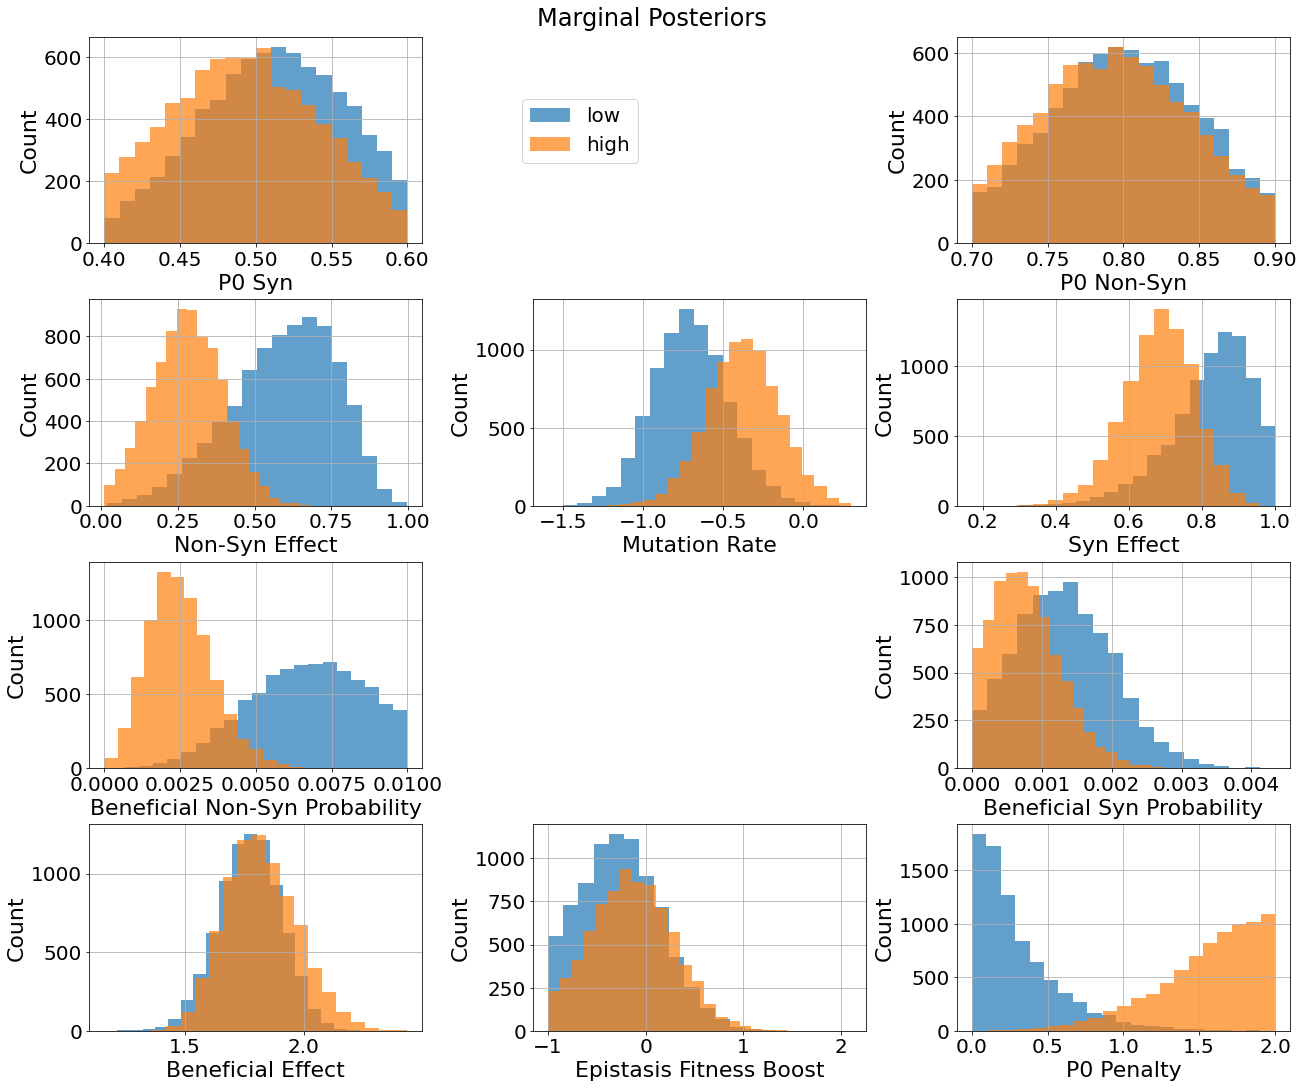

In [35]:
replica = 'B'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})

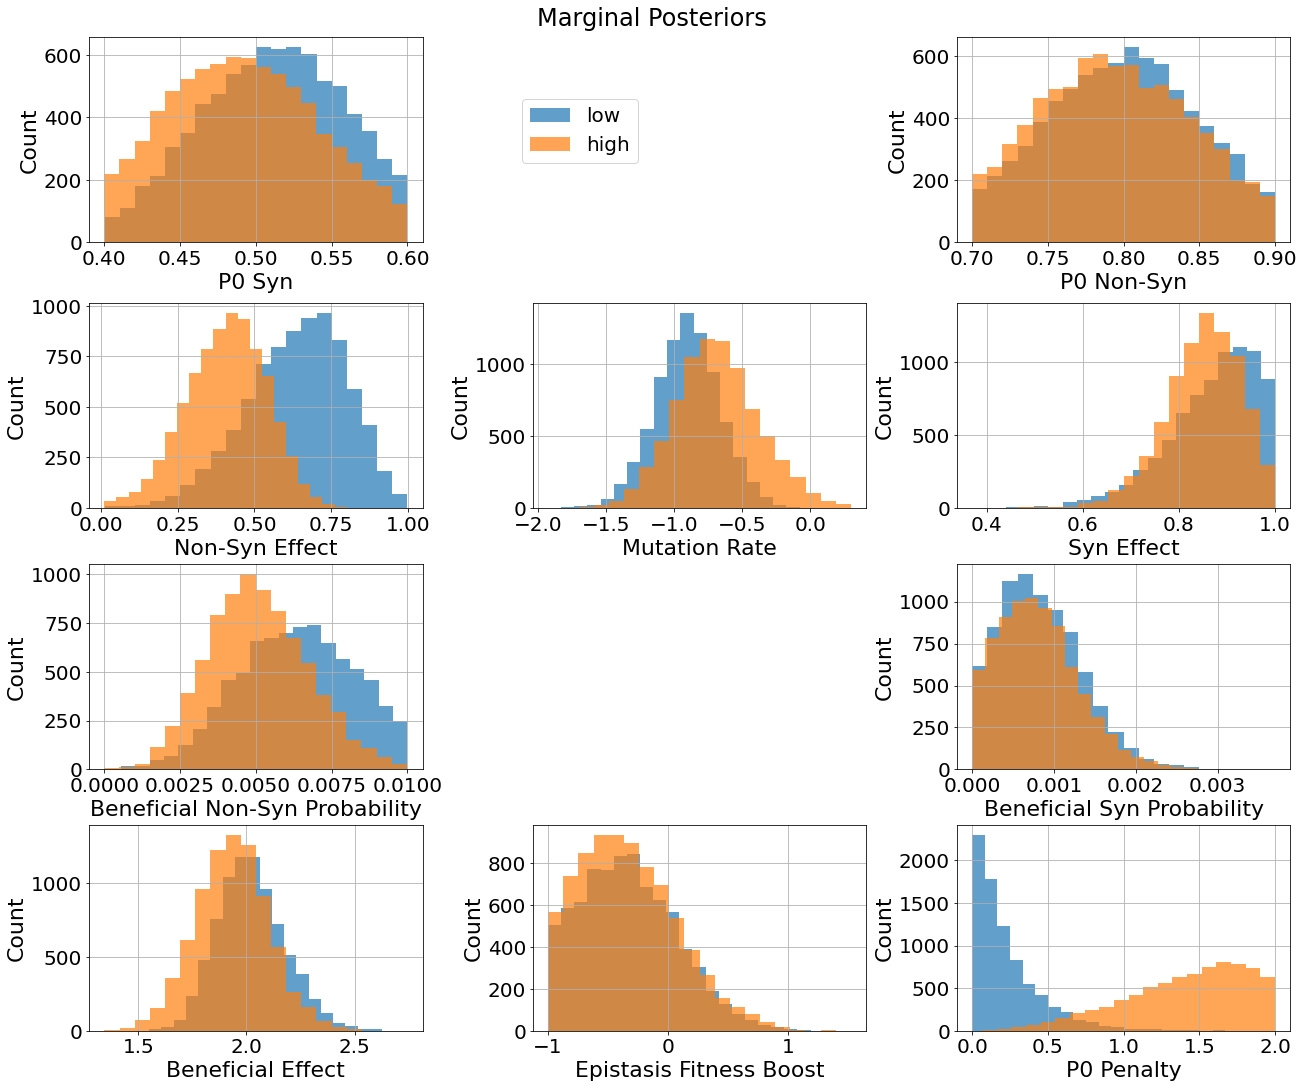

In [36]:
replica = 'C'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})